# Prepare Weather and NASA Firms to create Train data

## Look at the data

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
weather = pd.read_csv('hourly_weather_data.csv')
nasa = pd.read_csv('Wildfire_Data_2020-2023.csv')

In [3]:
weather.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,et0_fao_evapotranspiration,wind_speed_100m,wind_direction_100m
0,2020-01-01 00:00:00+00:00,58.700300,62.268870,45.8303,55.678288,0.0,0.004173,6.215479,239.74365
1,2020-01-01 01:00:00+00:00,54.380302,61.066536,41.2403,50.515940,0.0,0.001316,4.529580,212.90524
2,2020-01-01 02:00:00+00:00,57.080300,50.207703,38.7203,53.103203,0.0,0.000875,0.316360,224.99990
3,2020-01-01 03:00:00+00:00,50.420300,65.645630,39.3503,46.027035,0.0,0.000634,4.343468,168.11136
4,2020-01-01 04:00:00+00:00,53.120300,54.411290,37.1003,49.102360,0.0,0.000436,3.472758,194.93147


In [4]:
weather.dtypes

date                           object
temperature_2m                float64
relative_humidity_2m          float64
dew_point_2m                  float64
apparent_temperature          float64
precipitation                 float64
et0_fao_evapotranspiration    float64
wind_speed_100m               float64
wind_direction_100m           float64
dtype: object

In [5]:
nasa.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight
0,37.45576,-121.93266,298.7,0.38,0.58,1/4/20,1042,1,VIIRS,n,2.0NRT,276.9,0.2,N
1,37.31750,-122.09219,295.9,0.37,0.58,1/4/20,1042,1,VIIRS,n,2.0NRT,280.4,0.5,N
2,37.31704,-122.09343,301.3,0.42,0.45,1/5/20,1024,1,VIIRS,n,2.0NRT,280.6,0.9,N
3,37.31878,-122.09222,296.0,0.41,0.37,1/6/20,1006,1,VIIRS,n,2.0NRT,280.0,0.8,N
4,37.45645,-121.93143,305.3,0.41,0.37,1/6/20,1006,1,VIIRS,n,2.0NRT,276.6,0.9,N


In [6]:
nasa.dtypes

latitude      float64
longitude     float64
brightness    float64
scan          float64
track         float64
acq_date       object
acq_time        int64
satellite       int64
instrument     object
confidence     object
version        object
bright_t31    float64
frp           float64
daynight       object
dtype: object

In [7]:
nasa.confidence.value_counts()

n    8666
h    1028
l     366
Name: confidence, dtype: int64

The samples with `low (l)` confidence are the ones where NASA thinks that sunlight's glare could have caused pixel sensors to pick high values, and hence the satellite marked it as wildfire. <br />
We should remove these samples later. More details [here](https://www.earthdata.nasa.gov/learn/find-data/near-real-time/firms/viirs-i-band-375-m-active-fire-data).

## Deduplication of NASA

Much of the samples that exist in the dataset are from the same date and time. These samples just have slightly different `lat/long`, and their corresponding `brightness`.<br />
The rest of the features like `scan`, `track`, `satellite` etc. are the same. These samples does not add variance/diversity to the dataset, and may in turn lead to bias or create artificial importance of these fixed features.

Therefore, its better to remove such samples.

In [8]:
nasa[nasa.duplicated(subset=['acq_date', 'acq_time'])]

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight
1,37.31750,-122.09219,295.90,0.37,0.58,1/4/20,1042,1,VIIRS,n,2.0NRT,280.40,0.50,N
4,37.45645,-121.93143,305.30,0.41,0.37,1/6/20,1006,1,VIIRS,n,2.0NRT,276.60,0.90,N
6,37.45734,-121.93303,302.80,0.41,0.37,1/7/20,948,1,VIIRS,n,2.0NRT,275.90,0.60,N
7,37.31814,-122.09075,302.40,0.42,0.37,1/7/20,948,1,VIIRS,n,2.0NRT,280.10,1.00,N
8,37.18447,-121.68083,298.70,0.41,0.37,1/7/20,948,1,VIIRS,n,2.0NRT,276.20,0.80,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10045,37.03717,-121.52206,328.02,0.44,0.38,12/2/23,2053,1,VIIRS,n,2.0NRT,280.33,5.49,D
10048,37.18330,-121.68040,295.06,0.39,0.36,12/6/23,956,1,VIIRS,n,2.0NRT,280.88,0.63,N
10049,37.21344,-121.90060,295.62,0.39,0.36,12/6/23,956,1,VIIRS,n,2.0NRT,280.92,0.24,N
10053,37.18374,-121.67919,298.30,0.39,0.36,12/11/23,1002,1,VIIRS,n,2.0NRT,277.27,0.47,N


In [9]:
nasa.drop_duplicates(subset=['acq_date', 'acq_time'], inplace=True)

In [10]:
nasa.shape

(999, 14)

In [11]:
# Sanity check if weather set contains duplicate date-time
weather[weather.duplicated(subset=['date'])]

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,et0_fao_evapotranspiration,wind_speed_100m,wind_direction_100m


## Change date/time dtype of NASA dataset

In [12]:
# Step 1: Convert date columns to consistent format
weather['date'] = pd.to_datetime(weather['date'])
nasa['acq_date'] = pd.to_datetime(nasa['acq_date'], format='%m/%d/%y')

# Step 2: Convert time column to match weather format
nasa['acq_time'] = nasa['acq_time'].astype(str).str.zfill(4)  # Ensure leading zeros for hours < 10
nasa['acq_time'] = pd.to_datetime(nasa['acq_time'], format='%H%M').dt.time

# Step 3: Create new columns for date and time components
weather['time'] = weather['date'].dt.time
weather['date'] = weather['date'].dt.date

In [13]:
# Moving the time column to the front for ease of visualization
col = weather.columns.to_list()
col.remove('time')
col.insert(1, 'time')
weather = weather[col]
weather.head()

,date,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,et0_fao_evapotranspiration,wind_speed_100m,wind_direction_100m
0,2020-01-01,00:00:00,58.700300,62.268870,45.8303,55.678288,0.0,0.004173,6.215479,239.74365
1,2020-01-01,01:00:00,54.380302,61.066536,41.2403,50.515940,0.0,0.001316,4.529580,212.90524
2,2020-01-01,02:00:00,57.080300,50.207703,38.7203,53.103203,0.0,0.000875,0.316360,224.99990
3,2020-01-01,03:00:00,50.420300,65.645630,39.3503,46.027035,0.0,0.000634,4.343468,168.11136
4,2020-01-01,04:00:00,53.120300,54.411290,37.1003,49.102360,0.0,0.000436,3.472758,194.93147


In [14]:
nasa.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight
0,37.45576,-121.93266,298.7,0.38,0.58,2020-01-04,10:42:00,1,VIIRS,n,2.0NRT,276.9,0.2,N
2,37.31704,-122.09343,301.3,0.42,0.45,2020-01-05,10:24:00,1,VIIRS,n,2.0NRT,280.6,0.9,N
3,37.31878,-122.09222,296.0,0.41,0.37,2020-01-06,10:06:00,1,VIIRS,n,2.0NRT,280.0,0.8,N
5,37.18483,-121.67795,296.7,0.41,0.37,2020-01-07,09:48:00,1,VIIRS,n,2.0NRT,276.9,0.8,N
9,37.31736,-122.08982,302.0,0.39,0.36,2020-01-12,09:54:00,1,VIIRS,n,2.0NRT,274.3,0.5,N


## Round off NASA time to nearest hour

In [15]:
nasa['acq_time'] = pd.to_datetime(nasa['acq_time'], format='%H:%M:%S')

# Round to the nearest hour
nasa['round_time'] = nasa['acq_time'].dt.round('H')

# Convert back to time format (HH:MM:SS) 
nasa['round_time'] = nasa['round_time'].dt.time
nasa['acq_time'] = nasa['acq_time'].dt.time

## Merge both sets and get training data

In [16]:
weather.shape, nasa.shape

((35088, 10), (999, 15))

In [17]:
nasa['date_time'] = pd.to_datetime(nasa['acq_date'].astype(str) + ' ' + nasa['round_time'].astype(str))
weather['date_time'] = pd.to_datetime(weather['date'].astype(str) + ' ' + weather['time'].astype(str))

# Merging on date_time to get positive samples
positive = pd.merge(nasa, weather, on='date_time', how='inner')

In [18]:
positive.tail()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,date,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,et0_fao_evapotranspiration,wind_speed_100m,wind_direction_100m
994,36.97666,-121.54601,330.14,0.38,0.36,2023-12-12,21:03:00,1,VIIRS,n,...,2023-12-12,21:00:00,59.240300,68.296540,48.8003,55.944866,0.0,0.009498,8.276900,288.92474
995,37.09114,-122.15366,327.73,0.53,0.42,2023-12-13,20:46:00,1,VIIRS,n,...,2023-12-13,21:00:00,52.310303,86.623260,48.4403,51.354820,0.0,0.008042,1.613124,303.69010
996,37.45424,-121.93408,299.06,0.54,0.42,2023-12-23,09:38:00,1,VIIRS,n,...,2023-12-23,10:00:00,45.650300,100.000000,45.6503,43.369450,0.0,0.000000,1.500625,116.56499
997,37.45675,-121.93478,305.59,0.32,0.55,2023-12-24,09:17:00,1,VIIRS,n,...,2023-12-24,09:00:00,42.680298,82.809685,37.8203,37.939423,0.0,0.000000,5.188683,172.56868
998,37.45598,-121.93182,305.10,0.46,0.39,2023-12-28,09:43:00,1,VIIRS,n,...,2023-12-28,10:00:00,55.730300,84.812440,51.2303,52.837452,0.0,0.000342,15.350775,136.77144


In [19]:
positive.shape

(999, 26)

In [20]:
# Drop NASA features
nasa_cols = nasa.columns.to_list()
positive_only_weather = positive.drop(columns=nasa_cols)

In [21]:
positive_only_weather.head()

,date,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,et0_fao_evapotranspiration,wind_speed_100m,wind_direction_100m
0,2020-01-04,11:00:00,41.9603,92.626236,39.9803,37.764164,0.0,0.000000,6.219504,142.30570
1,2020-01-05,10:00:00,43.9403,88.903460,40.8803,40.114570,0.0,0.000000,9.712290,298.92633
2,2020-01-06,10:00:00,46.0103,85.677090,41.9603,42.985954,0.0,0.000000,6.579214,287.81897
3,2020-01-07,10:00:00,42.3203,64.397210,31.1603,36.644592,0.0,0.000484,6.803570,207.40749
4,2020-01-12,10:00:00,41.9603,89.123010,38.9903,37.676210,0.0,0.000000,0.447400,180.00000


In [22]:
positive_only_weather.shape

(999, 10)

In [23]:
positive_only_weather.to_csv('weather_positive_samples.csv', index=False)

# To be Continued from here


## Smoothen positive samples with X hours window

In [24]:
# Samples from different dates
nasa[~nasa['acq_date'].duplicated(keep=False)]

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,round_time,date_time
0,37.45576,-121.93266,298.70,0.38,0.58,2020-01-04,10:42:00,1,VIIRS,n,2.0NRT,276.90,0.20,N,11:00:00,2020-01-04 11:00:00
2,37.31704,-122.09343,301.30,0.42,0.45,2020-01-05,10:24:00,1,VIIRS,n,2.0NRT,280.60,0.90,N,10:00:00,2020-01-05 10:00:00
3,37.31878,-122.09222,296.00,0.41,0.37,2020-01-06,10:06:00,1,VIIRS,n,2.0NRT,280.00,0.80,N,10:00:00,2020-01-06 10:00:00
5,37.18483,-121.67795,296.70,0.41,0.37,2020-01-07,09:48:00,1,VIIRS,n,2.0NRT,276.90,0.80,N,10:00:00,2020-01-07 10:00:00
9,37.31736,-122.08982,302.00,0.39,0.36,2020-01-12,09:54:00,1,VIIRS,n,2.0NRT,274.30,0.50,N,10:00:00,2020-01-12 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10054,36.97666,-121.54601,330.14,0.38,0.36,2023-12-12,21:03:00,1,VIIRS,n,2.0NRT,291.13,2.34,D,21:00:00,2023-12-12 21:00:00
10056,37.09114,-122.15366,327.73,0.53,0.42,2023-12-13,20:46:00,1,VIIRS,n,2.0NRT,287.87,6.63,D,21:00:00,2023-12-13 21:00:00
10057,37.45424,-121.93408,299.06,0.54,0.42,2023-12-23,09:38:00,1,VIIRS,n,2.0NRT,278.06,1.04,N,10:00:00,2023-12-23 10:00:00
10058,37.45675,-121.93478,305.59,0.32,0.55,2023-12-24,09:17:00,1,VIIRS,n,2.0NRT,276.24,0.71,N,09:00:00,2023-12-24 09:00:00


In [25]:
# Samples from the dates
nasa[nasa['acq_date'].duplicated(keep=False)]

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,round_time,date_time
27,37.21408,-121.90261,295.60,0.41,0.37,2020-02-07,10:06:00,1,VIIRS,n,2.0NRT,279.00,0.40,N,10:00:00,2020-02-07 10:00:00
30,37.14733,-121.64178,330.70,0.39,0.44,2020-02-07,21:24:00,1,VIIRS,n,2.0NRT,294.30,0.90,D,21:00:00,2020-02-07 21:00:00
33,37.45810,-121.93336,298.30,0.40,0.60,2020-02-10,09:12:00,1,VIIRS,n,2.0NRT,277.90,0.40,N,09:00:00,2020-02-10 09:00:00
34,37.14628,-121.64363,330.10,0.48,0.48,2020-02-10,20:30:00,1,VIIRS,n,2.0NRT,295.00,1.70,D,20:00:00,2020-02-10 20:00:00
39,37.45597,-121.93024,302.50,0.46,0.39,2020-02-19,09:42:00,1,VIIRS,n,2.0NRT,277.80,0.60,N,10:00:00,2020-02-19 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10024,36.97908,-122.11514,334.38,0.47,0.40,2023-11-09,21:25:00,1,VIIRS,n,2.0NRT,282.68,7.00,D,21:00:00,2023-11-09 21:00:00
10026,37.45395,-121.93423,299.02,0.38,0.58,2023-11-12,10:47:00,1,VIIRS,n,2.0NRT,275.89,0.56,N,11:00:00,2023-11-12 11:00:00
10027,37.12435,-122.16129,338.72,0.62,0.54,2023-11-12,20:25:00,1,VIIRS,n,2.0NRT,290.46,7.22,D,20:00:00,2023-11-12 20:00:00
10028,37.45317,-121.93156,296.10,0.42,0.46,2023-11-13,10:28:00,1,VIIRS,n,2.0NRT,280.62,0.59,N,10:00:00,2023-11-13 10:00:00


The samples from the same date have the time apart from each other. It may signify the start or end of wildfire.

In [26]:
print(nasa['date_time'])

0       2020-01-04 11:00:00
2       2020-01-05 10:00:00
3       2020-01-06 10:00:00
5       2020-01-07 10:00:00
9       2020-01-12 10:00:00
                ...        
10054   2023-12-12 21:00:00
10056   2023-12-13 21:00:00
10057   2023-12-23 10:00:00
10058   2023-12-24 09:00:00
10059   2023-12-28 10:00:00
Name: date_time, Length: 999, dtype: datetime64[ns]


In [27]:
merged_df = pd.merge(weather, nasa, on='date_time', how='left', suffixes=('_weather', '_nasa'))

# Filter out rows where there was a match
matched_rows = merged_df.dropna(subset=['brightness'])

# Filter out rows where there was no match
unmatched_rows = merged_df[merged_df['brightness'].isna()]

In [28]:
merged_df.columns

Index(['date', 'time', 'temperature_2m', 'relative_humidity_2m',
       'dew_point_2m', 'apparent_temperature', 'precipitation',
       'et0_fao_evapotranspiration', 'wind_speed_100m', 'wind_direction_100m',
       'date_time', 'latitude', 'longitude', 'brightness', 'scan', 'track',
       'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence',
       'version', 'bright_t31', 'frp', 'daynight', 'round_time'],
      dtype='object')

In [29]:
merged_df.head()

,date,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,et0_fao_evapotranspiration,wind_speed_100m,wind_direction_100m,...,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,round_time
0,2020-01-01,00:00:00,58.700300,62.268870,45.8303,55.678288,0.0,0.004173,6.215479,239.74365,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,01:00:00,54.380302,61.066536,41.2403,50.515940,0.0,0.001316,4.529580,212.90524,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,02:00:00,57.080300,50.207703,38.7203,53.103203,0.0,0.000875,0.316360,224.99990,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,03:00:00,50.420300,65.645630,39.3503,46.027035,0.0,0.000634,4.343468,168.11136,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,04:00:00,53.120300,54.411290,37.1003,49.102360,0.0,0.000436,3.472758,194.93147,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
matched_rows.shape

(999, 26)

In [31]:
unmatched_rows.shape

(34096, 26)

In [32]:
unmatched = pd.merge(weather, nasa, on='date_time', how='left', indicator=True).query('_merge == "left_only"')

In [33]:
unmatched

,date,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,et0_fao_evapotranspiration,wind_speed_100m,wind_direction_100m,...,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,round_time,_merge
0,2020-01-01,00:00:00,58.700300,62.268870,45.830300,55.678288,0.0,0.004173,6.215479,239.74365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,2020-01-01,01:00:00,54.380302,61.066536,41.240300,50.515940,0.0,0.001316,4.529580,212.90524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,2020-01-01,02:00:00,57.080300,50.207703,38.720300,53.103203,0.0,0.000875,0.316360,224.99990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,2020-01-01,03:00:00,50.420300,65.645630,39.350300,46.027035,0.0,0.000634,4.343468,168.11136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,2020-01-01,04:00:00,53.120300,54.411290,37.100300,49.102360,0.0,0.000436,3.472758,194.93147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35090,2024-01-01,19:00:00,50.510300,91.647210,48.170300,48.790024,0.0,0.005746,3.202897,282.09473,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
35091,2024-01-01,20:00:00,53.660300,84.401740,49.070297,52.423836,0.0,0.008103,3.042649,323.97253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
35092,2024-01-01,21:00:00,55.640297,80.395310,49.700300,54.713180,0.0,0.008827,2.409323,291.80148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
35093,2024-01-01,22:00:00,56.630302,79.403760,50.330300,55.378254,0.0,0.007796,3.861661,259.99210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [34]:
weather['is_possible_ff'] = weather['date_time'].isin(nasa['date_time'].tolist())

In [35]:
weather[weather['is_possible_ff'] == True].shape

(992, 12)

In [36]:
weather['target'] = weather['is_possible_ff'].astype(int)

In [62]:
weather[weather['target'] == 1].shape

(992, 13)

In [89]:
weather['target']

,date,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,et0_fao_evapotranspiration,wind_speed_100m,wind_direction_100m,date_time,is_possible_ff,target
0,2020-01-01,00:00:00,58.70,62.27,45.83,55.68,0.00,0.00,6.22,239.74,2020-01-01 00:00:00,False,0
1,2020-01-01,01:00:00,54.38,61.07,41.24,50.52,0.00,0.00,4.53,212.91,2020-01-01 01:00:00,False,0
2,2020-01-01,02:00:00,57.08,50.21,38.72,53.10,0.00,0.00,0.32,225.00,2020-01-01 02:00:00,False,0
3,2020-01-01,03:00:00,50.42,65.65,39.35,46.03,0.00,0.00,4.34,168.11,2020-01-01 03:00:00,False,0
4,2020-01-01,04:00:00,53.12,54.41,37.10,49.10,0.00,0.00,3.47,194.93,2020-01-01 04:00:00,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35083,2024-01-01,19:00:00,50.51,91.65,48.17,48.79,0.00,0.01,3.20,282.09,2024-01-01 19:00:00,False,0
35084,2024-01-01,20:00:00,53.66,84.40,49.07,52.42,0.00,0.01,3.04,323.97,2024-01-01 20:00:00,False,0
35085,2024-01-01,21:00:00,55.64,80.40,49.70,54.71,0.00,0.01,2.41,291.80,2024-01-01 21:00:00,False,0
35086,2024-01-01,22:00:00,56.63,79.40,50.33,55.38,0.00,0.01,3.86,259.99,2024-01-01 22:00:00,False,0


In [39]:
weather.to_csv('weather_features_target_v1.csv', index=False)

In [40]:
%pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [57]:
weather.dtypes

date                                  object
time                                  object
temperature_2m                       float64
relative_humidity_2m                 float64
dew_point_2m                         float64
apparent_temperature                 float64
precipitation                        float64
et0_fao_evapotranspiration           float64
wind_speed_100m                      float64
wind_direction_100m                  float64
date_time                     datetime64[ns]
is_possible_ff                          bool
target                                 int32
dtype: object

In [43]:
target_column = 'target'

numerical_features = weather.select_dtypes('number').columns.tolist()

# Exclude the target column from the list of numerical features
numerical_features.remove(target_column)

num_features_count = len(numerical_features)
print(f"Number of numerical features: {num_features_count}")

Number of numerical features: 8


### Identifying Outliers

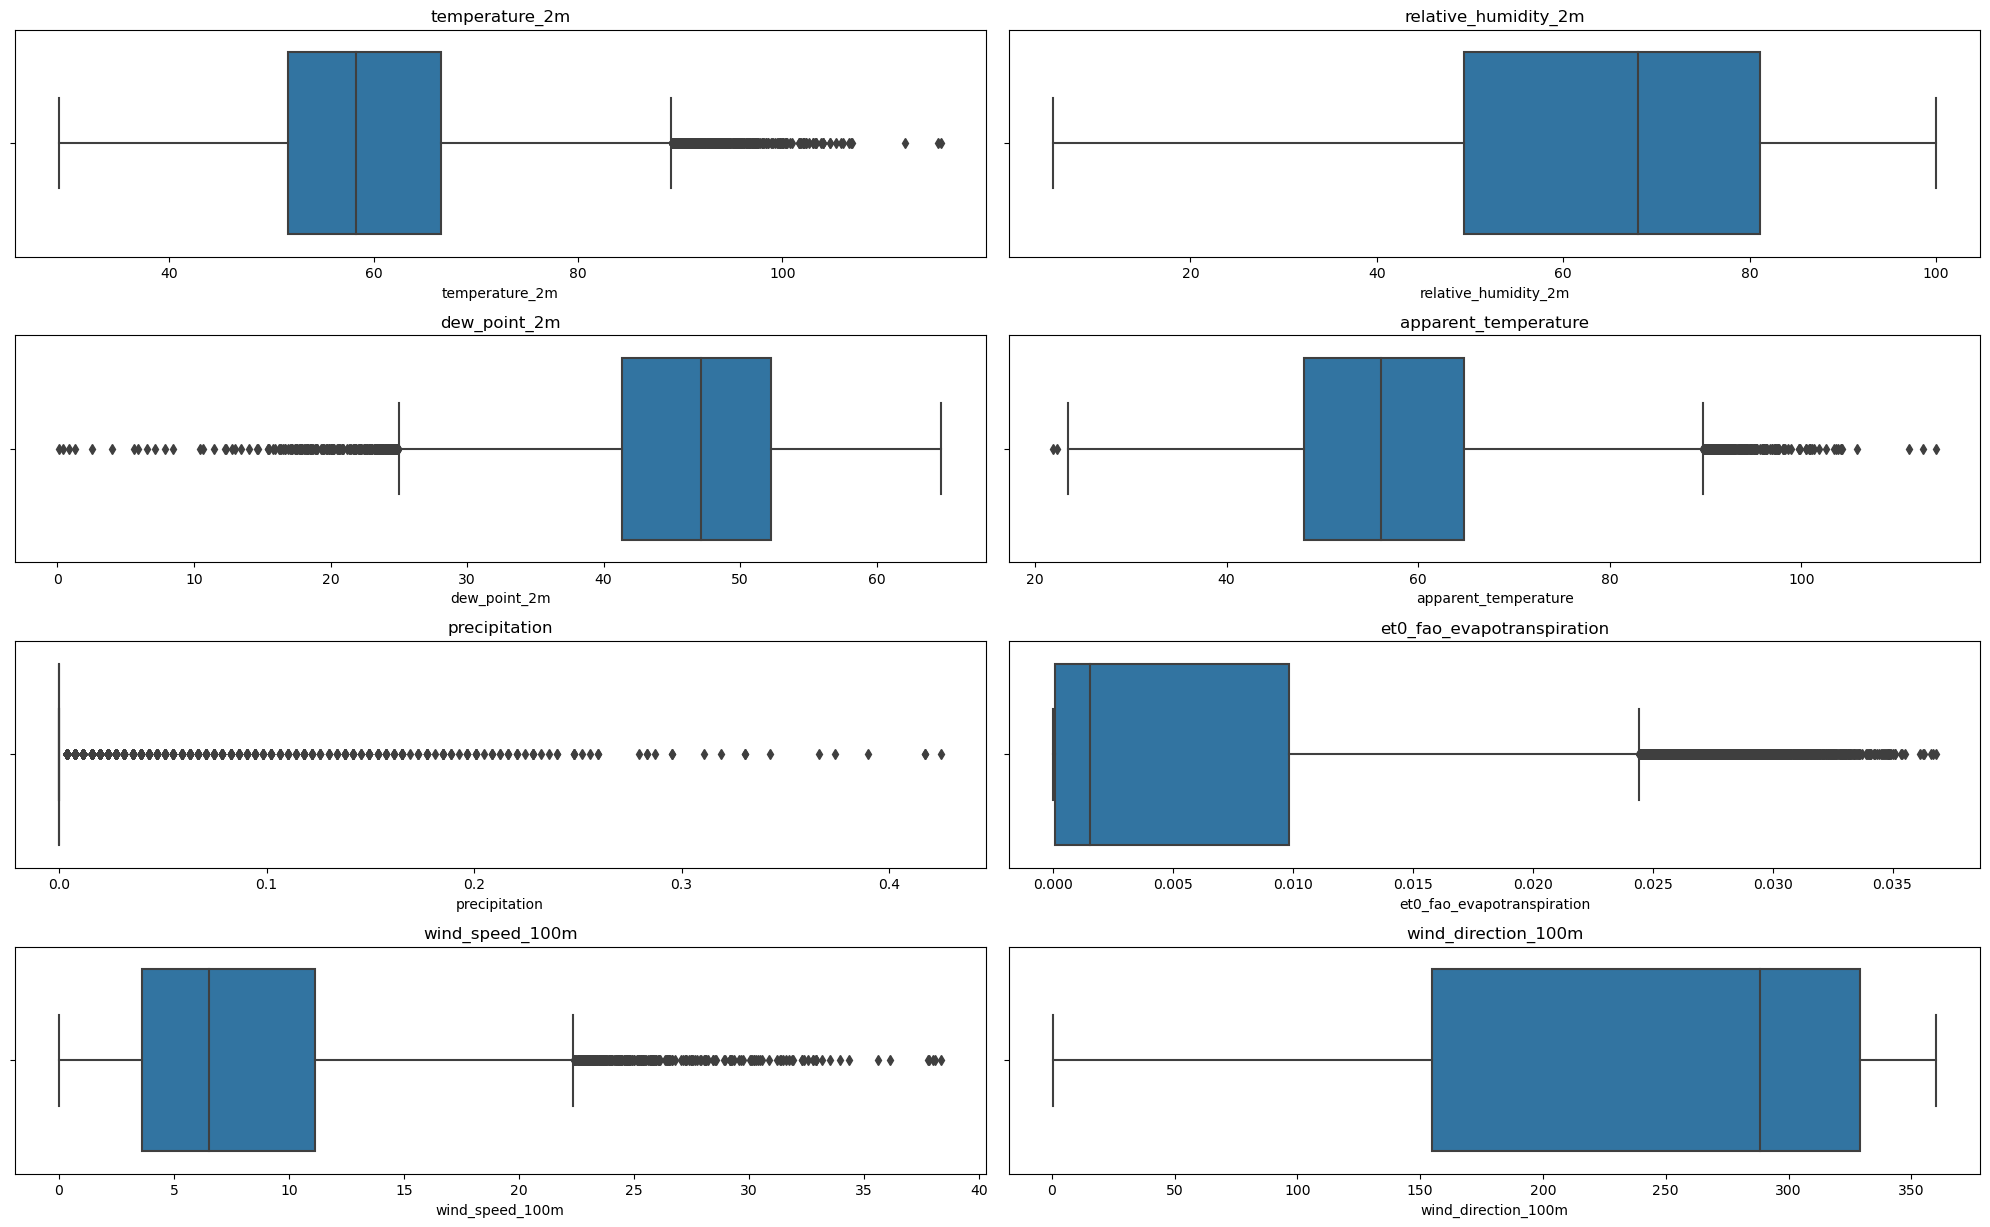

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_outliers(data, numerical_features, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

    # Flatten the axes array for ease of indexing
    axes = axes.flatten()

    for i, feature in enumerate(numerical_features):
        sns.boxplot(x=data[feature], ax=axes[i])
        #axes[i].set_title(f'Box Plot for {feature}')
        axes[i].set_title(f'{feature}')

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Specify the number of rows and columns for the grid
rows = 5
cols = 2

# Visualize outliers in the training set
visualize_outliers(weather, numerical_features, rows, cols)

In [49]:
pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/e8/37/3afd3c02798734efcd7840bfa872d3efc06f5d5c92f9613fea3ff5b4311f/catboost-1.2.3-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/de/5e/fcbb22c68208d39edff467809d06c9d81d7d27426460ebc598e55130c1aa/graphviz-0.20.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/101.1 MB 8.9 MB/s eta 0:00:12
   ---------------------------------------- 0.9/101.1 MB 9.6 MB/s eta 0:00:11
   ---------------------------------------- 1.0/101.1 MB 11.0 MB/s eta 0:00:10
    --------------------------------------- 1.9/101.1 MB 10.0 MB/s eta 0:00:10
   - -------------------------------------- 2.5/101.1 MB 11.5 MB/s eta 0:00:09
   - -------------------------------------- 3.1/101.1 MB 11.7 MB/s eta 0:00:09
   - -------------------------------------- 4

In [50]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from lazypredict.Supervised import LazyClassifier
import xgboost
import catboost
import lightgbm as lightgbm

In [163]:
weather.dtypes

date                                  object
time                                  object
temperature_2m                       float64
relative_humidity_2m                 float64
dew_point_2m                         float64
apparent_temperature                 float64
precipitation                        float64
et0_fao_evapotranspiration           float64
wind_speed_100m                      float64
wind_direction_100m                  float64
date_time                     datetime64[ns]
is_possible_ff                          bool
target                                 int32
dtype: object

In [156]:
train = weather.drop(columns=['date_time','target','is_possible_ff'])
test = weather['target']

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size = 0.2, random_state = 50)

In [66]:
clf = LazyClassifier(verbose=3,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

  3%|██▊                                                                                | 1/29 [00:03<01:51,  3.97s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.9720718153320034, 'Balanced Accuracy': 0.6094797249161396, 'ROC AUC': 0.6094797249161396, 'F1 Score': 0.9662803882700103, 'Time taken': 3.970217227935791}



  7%|█████▋                                                                             | 2/29 [00:06<01:29,  3.30s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.969222000569963, 'Balanced Accuracy': 0.6056463074538275, 'ROC AUC': 0.6056463074538274, 'F1 Score': 0.9641083186497038, 'Time taken': 2.830045700073242}
{'Model': 'BernoulliNB', 'Accuracy': 0.9707893986890852, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.9564005745454035, 'Time taken': 0.08420586585998535}



 14%|███████████▍                                                                       | 4/29 [00:07<00:36,  1.48s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.9707893986890852, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.9564005745454035, 'Time taken': 0.6919384002685547}



 21%|█████████████████▏                                                                 | 6/29 [00:08<00:20,  1.13it/s]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.9623824451410659, 'Balanced Accuracy': 0.6659957828111966, 'ROC AUC': 0.6659957828111965, 'F1 Score': 0.9622930055653878, 'Time taken': 0.41393566131591797}
{'Model': 'DummyClassifier', 'Accuracy': 0.9707893986890852, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.9564005745454035, 'Time taken': 0.09242749214172363}



 28%|██████████████████████▉                                                            | 8/29 [00:08<00:12,  1.73it/s]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.9515531490453121, 'Balanced Accuracy': 0.6060085990556074, 'ROC AUC': 0.6060085990556074, 'F1 Score': 0.9530517994343854, 'Time taken': 0.14847302436828613}



 31%|█████████████████████████▊                                                         | 9/29 [00:10<00:20,  1.01s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.9710743801652892, 'Balanced Accuracy': 0.5332656721547401, 'ROC AUC': 0.5332656721547401, 'F1 Score': 0.960054797090127, 'Time taken': 2.527404546737671}
{'Model': 'GaussianNB', 'Accuracy': 0.5758050726702765, 'Balanced Accuracy': 0.696357752216888, 'ROC AUC': 0.696357752216888, 'F1 Score': 0.7041995934869708, 'Time taken': 0.08205246925354004}



 38%|███████████████████████████████                                                   | 11/29 [00:11<00:13,  1.38it/s]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.9682245654032487, 'Balanced Accuracy': 0.4986789960369881, 'ROC AUC': 0.4986789960369881, 'F1 Score': 0.9551167688543162, 'Time taken': 0.4555320739746094}



 41%|█████████████████████████████████▉                                                | 12/29 [01:35<05:19, 18.78s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.9405813622114563, 'Balanced Accuracy': 0.4962696852860206, 'ROC AUC': 0.49626968528602067, 'F1 Score': 0.941727056729341, 'Time taken': 83.6551570892334}


 48%|███████████████████████████████████████▌                                          | 14/29 [03:14<07:04, 28.33s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.9414363066400684, 'Balanced Accuracy': 0.49671001994035796, 'ROC AUC': 0.49671001994035796, 'F1 Score': 0.9421777327665987, 'Time taken': 99.21961998939514}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.9707893986890852, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.9564005745454035, 'Time taken': 0.1933882236480713}



 52%|██████████████████████████████████████████▍                                       | 15/29 [03:18<05:07, 21.97s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.9707893986890852, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.9564005745454035, 'Time taken': 4.3718581199646}



 55%|█████████████████████████████████████████████▏                                    | 16/29 [03:19<03:28, 16.05s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.9707893986890852, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.9564005745454035, 'Time taken': 0.4387552738189697}



 59%|████████████████████████████████████████████████                                  | 17/29 [03:19<02:19, 11.58s/it]

{'Model': 'NearestCentroid', 'Accuracy': 0.5168139070960388, 'Balanced Accuracy': 0.4885520149785382, 'ROC AUC': 0.4885520149785382, 'F1 Score': 0.6575158305630062, 'Time taken': 0.22562861442565918}


 69%|████████████████████████████████████████████████████████▌                         | 20/29 [03:19<00:44,  4.94s/it]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.9707893986890852, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.9564005745454035, 'Time taken': 0.17325162887573242}
{'Model': 'Perceptron', 'Accuracy': 0.9459960102593331, 'Balanced Accuracy': 0.5014241067113445, 'ROC AUC': 0.5014241067113445, 'F1 Score': 0.9447214918283823, 'Time taken': 0.11929035186767578}



 72%|███████████████████████████████████████████████████████████▍                      | 21/29 [03:19<00:29,  3.70s/it]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.7460815047021944, 'Balanced Accuracy': 0.7958859139450047, 'ROC AUC': 0.7958859139450046, 'F1 Score': 0.8302614226915049, 'Time taken': 0.10327291488647461}


 79%|█████████████████████████████████████████████████████████████████                 | 23/29 [03:33<00:27,  4.62s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9715018523795953, 'Balanced Accuracy': 0.5926267215116009, 'ROC AUC': 0.5926267215116009, 'F1 Score': 0.964872816670111, 'Time taken': 13.545894861221313}
{'Model': 'RidgeClassifier', 'Accuracy': 0.9707893986890852, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.9564005745454035, 'Time taken': 0.12248778343200684}



 83%|███████████████████████████████████████████████████████████████████▊              | 24/29 [03:33<00:16,  3.35s/it]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.9707893986890852, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.9564005745454035, 'Time taken': 0.1450343132019043}



 86%|██████████████████████████████████████████████████████████████████████▋           | 25/29 [03:34<00:09,  2.49s/it]

{'Model': 'SGDClassifier', 'Accuracy': 0.9675121117127387, 'Balanced Accuracy': 0.5006776857728947, 'ROC AUC': 0.5006776857728947, 'F1 Score': 0.9550112452259222, 'Time taken': 0.3843541145324707}



 90%|█████████████████████████████████████████████████████████████████████████▌        | 26/29 [05:10<01:29, 29.90s/it]

{'Model': 'SVC', 'Accuracy': 0.9707893986890852, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.9564005745454035, 'Time taken': 96.42814683914185}



 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [05:11<00:16, 16.46s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.9685095468794528, 'Balanced Accuracy': 0.6171075383144848, 'ROC AUC': 0.6171075383144848, 'F1 Score': 0.9642462225648738, 'Time taken': 0.6947140693664551}
[LightGBM] [Info] Number of positive: 787, number of negative: 27283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2122
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028037 -> initscore=-3.545791
[LightGBM] [Info] Start training from score -3.545791


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [05:12<00:00, 10.78s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.9707893986890852, 'Balanced Accuracy': 0.6372068463088858, 'ROC AUC': 0.6372068463088858, 'F1 Score': 0.9668347313384575, 'Time taken': 1.3946585655212402}


In [60]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
QuadraticDiscriminantAnalysis,0.75,0.80,0.80,0.83,0.14
GaussianNB,0.58,0.70,0.70,0.70,0.10
DecisionTreeClassifier,0.96,0.67,0.67,0.96,0.41
LGBMClassifier,0.97,0.64,0.64,0.97,0.99
XGBClassifier,0.97,0.62,0.62,0.96,1.47
AdaBoostClassifier,0.97,0.61,0.61,0.97,3.31
ExtraTreeClassifier,0.95,0.61,0.61,0.95,0.12
BaggingClassifier,0.97,0.61,0.61,0.96,2.74
RandomForestClassifier,0.97,0.59,0.59,0.96,13.67


In [159]:
# X_train.dtypes
X_test.dtypes

date                           object
time                           object
temperature_2m                float64
relative_humidity_2m          float64
dew_point_2m                  float64
apparent_temperature          float64
precipitation                 float64
et0_fao_evapotranspiration    float64
wind_speed_100m               float64
wind_direction_100m           float64
dtype: object

In [191]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

weather['year'] = weather['date_time'].dt.year
weather['month'] = weather['date_time'].dt.month
weather['day'] = weather['date_time'].dt.day
weather['hour'] = weather['date_time'].dt.hour

weather['is_possible_ff'] = weather['is_possible_ff'].astype(int)

X = weather.drop(['date', 'time', 'date_time', 'target','is_possible_ff'], axis=1)  # Dropping non-numeric and target columns
y = weather['target']

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Scale your features to improve model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Predict on the test set
predictions = log_reg.predict(X_test_scaled)

print("Predictions:", predictions)


Predictions: [0 0 0 ... 0 0 0]


In [192]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

conf_matrix = confusion_matrix(y_test, predictions)

print("LogisticRegression Confusion Matrix:\n", conf_matrix)


# Calculate precision, recall, and F1 score & roc_auc
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

LogisticRegression Confusion Matrix:
 [[6800    0]
 [ 218    0]]
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [186]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

# Initialize and train the SGD model
sgd_clf = SGDClassifier(loss="log_loss")  # "log" loss makes it logistic regression
sgd_clf.fit(X_train, y_train)

# Predict on the test set
predictions = sgd_clf.predict(X_test)

print("SGD Classifier Predictions:", predictions)

conf_matrix = confusion_matrix(y_test, predictions)

print("SGD Classifier Confusion Matrix:\n", conf_matrix)

# Calculate precision, recall, and F1 score & roc_auc
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

SGD Classifier Predictions: [0 0 0 ... 0 0 0]
SGD Classifier Confusion Matrix:
 [[6800    0]
 [ 218    0]]
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [187]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import confusion_matrix

ada_boost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_boost_model.fit(X_train, y_train)

predictions = ada_boost_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, predictions)
print("AdaBoostClassifier Predictions:", predictions)

print("AdaBoostClassifier Confusion Matrix:\n", conf_matrix)

# Calculate precision, recall, and F1 score & roc_auc
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

AdaBoostClassifier Predictions: [0 0 0 ... 0 0 0]
AdaBoostClassifier Confusion Matrix:
 [[6761   39]
 [ 182   36]]
Precision: 0.4800
Recall: 0.1651
F1 Score: 0.2457


In [188]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_clf.fit(X_train, y_train)

predictions = random_forest_clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, predictions)
print("RandomForestClassifier Predictions:", predictions)

print("RandomForestClassifier Confusion Matrix:\n", conf_matrix)

# Calculate precision, recall, and F1 score & roc_auc
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

RandomForestClassifier Predictions: [0 0 0 ... 0 0 0]
RandomForestClassifier Confusion Matrix:
 [[6784   16]
 [ 198   20]]
Precision: 0.5556
Recall: 0.0917
F1 Score: 0.1575


In [189]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
xgb_clf.fit(X_train, y_train)

predictions = xgb_clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, predictions)
print("XGBClassifier Predictions:", predictions)

print("XGBClassifier Confusion Matrix:\n", conf_matrix)

# Calculate precision, recall, and F1 score & roc_auc
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

XGBClassifier Predictions: [0 0 0 ... 0 0 0]
XGBClassifier Confusion Matrix:
 [[6614  186]
 [  97  121]]
Precision: 0.3941
Recall: 0.5550
F1 Score: 0.4610


In [182]:
# 37000 ROWs - Weather , 1000 Postive sample - Increase NASA sensros dates etc
# All are result are skewed.

In [117]:
validation = pd.read_csv('validation_2024_weather_v1.csv')

In [118]:
train = weather.copy()

In [119]:
validation.dtypes

date                           object
temperature_2m                float64
relative_humidity_2m            int64
dew_point_2m                  float64
apparent_temperature          float64
precipitation                 float64
et0_fao_evapotranspiration    float64
wind_speed_100m               float64
wind_direction_100m             int64
dtype: object

In [120]:
train_v2 = train.drop(columns=['date_time','is_possible_ff'])
train_v2.dtypes

date                           object
time                           object
temperature_2m                float64
relative_humidity_2m          float64
dew_point_2m                  float64
apparent_temperature          float64
precipitation                 float64
et0_fao_evapotranspiration    float64
wind_speed_100m               float64
wind_direction_100m           float64
target                          int32
dtype: object

In [121]:
validation.shape,train_v2.shape

((1440, 9), (35088, 11))

In [122]:
# Step 1: Convert date columns to consistent format
validation['date'] = pd.to_datetime(validation['date'])

# Step 3: Create new columns for date and time components
validation['time'] = validation['date'].dt.time
validation['date'] = validation['date'].dt.date

In [123]:
# Moving the time column to the front for ease of visualization
col = validation.columns.to_list()
col.remove('time')
col.insert(1, 'time')
validation = validation[col]
validation.head()

,date,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,et0_fao_evapotranspiration,wind_speed_100m,wind_direction_100m
0,2024-01-02,00:00:00,44.60,90,41.90,40.40,0.00,0.00,9.20,121
1,2024-01-02,01:00:00,43.40,90,40.60,39.00,0.00,0.00,10.20,138
2,2024-01-02,02:00:00,43.00,89,40.20,38.50,0.00,0.00,11.80,130
3,2024-01-02,03:00:00,42.60,91,40.10,38.30,0.00,0.00,12.00,141
4,2024-01-02,04:00:00,43.70,90,40.80,39.50,0.00,0.00,12.70,135


In [124]:
X = train_v2.drop(columns=['date','time','target'])
y = train_v2['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [125]:
X_train.dtypes

temperature_2m                float64
relative_humidity_2m          float64
dew_point_2m                  float64
apparent_temperature          float64
precipitation                 float64
et0_fao_evapotranspiration    float64
wind_speed_100m               float64
wind_direction_100m           float64
dtype: object

In [126]:
validation = validation.drop(columns=['date','time'])

In [127]:
validation.dtypes

temperature_2m                float64
relative_humidity_2m            int64
dew_point_2m                  float64
apparent_temperature          float64
precipitation                 float64
et0_fao_evapotranspiration    float64
wind_speed_100m               float64
wind_direction_100m             int64
dtype: object

In [128]:
model = AdaBoostClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [129]:
y_pred = model.predict(validation)

In [138]:
for row,each_value in enumerate(y_pred):
    if each_value == 1:
        print(row)

108
231
1095
1096
1382
1385


In [142]:
orginal_validation = pd.read_csv('validation_2024_weather_v1.csv')

rows_to_show = [108, 231, 1095, 1096, 1382, 1385] # this is output I got from above.
orginal_validation.iloc[rows_to_show]


,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,et0_fao_evapotranspiration,wind_speed_100m,wind_direction_100m
108,2024-01-06T12:00,59.50,48,40.00,55.70,0.00,0.22,6.20,173
231,2024-01-11T15:00,51.60,40,27.90,45.60,0.00,0.18,8.40,353
1095,2024-02-16T15:00,65.20,46,43.90,62.10,0.00,0.16,8.30,178
1096,2024-02-16T16:00,64.10,52,45.90,60.70,0.00,0.16,12.10,190
1382,2024-02-28T14:00,63.70,36,36.10,61.00,0.00,0.40,6.00,25
1385,2024-02-28T17:00,62.20,43,39.50,57.70,0.00,0.15,13.40,352
